# Lösung zum Übungsblatt: Trinkgeld-Analyse und Log-Loss

**Inhalt dieses Notebooks:**

- Aufgabe 1: Analyse der Trinkgeldrate
    - Analyse des fehlerhaften Ansatzes (Version 1) und Diagnose des Problems.
    - Analyse des korrekten Ansatzes (Version 2) und Erklärung der Lösung.
    - Fazit und Vergleich.
- Aufgabe 2: Berechnung des Log-Loss
    - Implementierung der Log-Loss-Berechnung in Python.
- Aufgabe 3: Konzeption der Modellerweiterung
    - Ein Plan zur Umstellung eines Klassifikationsmodells auf Wahrscheinlichkeitsprognosen.

___

## Teil 1: Analyse der Trinkgeldrate (Aufgabe 1)

**Problemstellung**: Zwei Code-Versionen berechnen die Veränderung der Trinkgeldrate über die Zeit und kommen zu unterschiedlichen Ergebnissen. Wir sollen herausfinden, warum und welche Version korrekt ist.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    orders = pd.read_parquet('orders.parquet')
    tips = pd.read_csv('tip25_trainingsdaten.csv')
    orders['order_date'] = pd.to_datetime(orders['order_date'])
except FileNotFoundError:
    print("FEHLER: Stellen Sie sicher, dass die Dateien 'orders.parquet' und 'tip25_trainingdata.csv' im richtigen Verzeichnis liegen.")

___
### 1.1 Untersuchung des fehlerhaften Ansatzes (Version 1)

Zuerst replizieren wir den Ansatz aus Lösung_Analyse_Version_1.ipynb. Dieser Ansatz berechnet die Wochen manuell und nutzt zur Berechnung der Rate .sum() und .count().

**Analyse-Schritte:**

Wir verbinden orders und tips mit einem left join. Das bedeutet, wir behalten alle Bestellungen aus orders, auch wenn es für sie keine Trinkgeld-Info in tips gibt. Für diese Bestellungen wird in der tip-Spalte ein NaN (Not a Number) eingetragen.
Wir berechnen die Rate als Anzahl Bestellungen mit Trinkgeld / Anzahl aller Bestellungen.

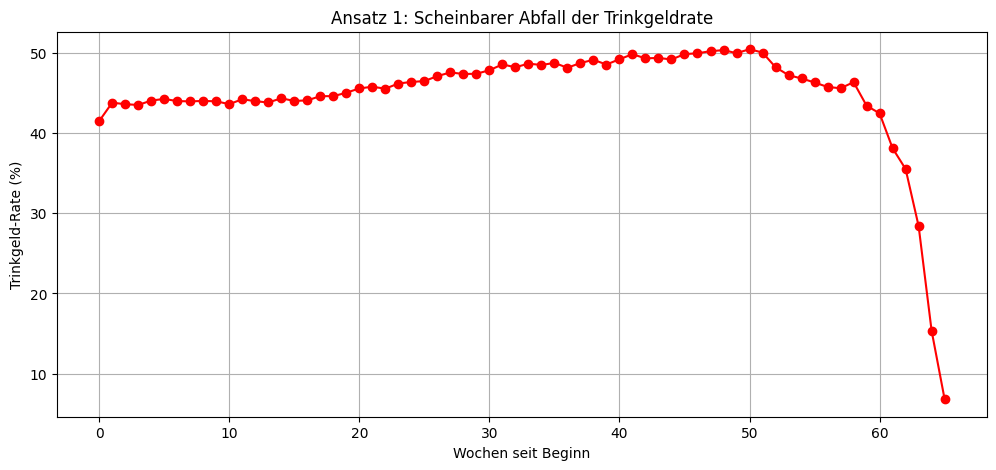

In [17]:
# --- Schritt 2: Ansatz 1 replizieren ---
# Daten mit left join verbinden
orders_with_tips_v1 = orders.merge(tips, on="order_id", how="left")

# Wochen manuell berechnen
orders_with_tips_v1['weeks_since_start'] = ((orders_with_tips_v1['order_date'] - orders_with_tips_v1['order_date'].min())
                                           .dt.total_seconds() / (60*60*24*7)).astype(int)

# Berechnung der Rate pro Woche
# .agg() führt mehrere Aggregationen gleichzeitig aus
weekly_percentages_v1 = orders_with_tips_v1.groupby("weeks_since_start").agg(
    total_orders=("order_id", "count"),  # Zählt ALLE Bestellungen
    tipped_orders=("tip", "sum")         # Summiert die 'tip'-Spalte (NaN wird als 0 behandelt)
)
weekly_percentages_v1["tip_percentage"] = 100 * weekly_percentages_v1["tipped_orders"] / weekly_percentages_v1["total_orders"]

# Plot erstellen
plt.figure(figsize=(12, 5))
plt.plot(weekly_percentages_v1.index, weekly_percentages_v1['tip_percentage'], marker='o', color='red')
plt.title('Ansatz 1: Scheinbarer Abfall der Trinkgeldrate')
plt.xlabel('Wochen seit Beginn')
plt.ylabel('Trinkgeld-Rate (%)')
plt.grid(True)
plt.show()

#### Diagnose des Problems in Version 1

Der Plot zeigt einen unerklärlichen, starken Abfall der Trinkgeldrate in den letzten Wochen. Wie im Vorlesungs-Notebook korrekt analysiert, liegt die Ursache in der Berechnungsmethode in Kombination mit den Daten:

- left join & Testdaten: Die letzten Bestellungen vieler User gehören zum Test-Set, für das keine Trinkgeld-Informationen in tip25_trainingdata.csv enthalten sind. Der left join erzeugt für diese Bestellungen NaN-Werte in der tip-Spalte.
- Die fehlerhafte Formel: Die Rate wird als tip.sum() / order_id.count() berechnet.
    - order_id.count() zählt alle Zeilen, auch die mit NaN im tip.
    - tip.sum() behandelt NaN wie 0.
- Konsequenz: In den letzten Wochen, wo viele NaNs vorkommen, bleibt der Nenner (total_orders) groß, während der Zähler (tipped_orders) klein bleibt. Dies drückt die berechnete Rate künstlich nach unten. Der Ansatz ist also falsch.

___
#### 1.2 Untersuchung des korrekten Ansatzes (Version 2)
Nun replizieren wir den Ansatz aus Lösung_Analyse_Version_2.ipynb. Der entscheidende Unterschied liegt in der Berechnung der Rate.

**Analyse-Schritte:**

Auch hier wird ein left join verwendet.
Die Wochen werden eleganter über dt.to_period('W') bestimmt, was saubere Kalenderwochen erzeugt.
Die Rate wird mit .mean() berechnet.

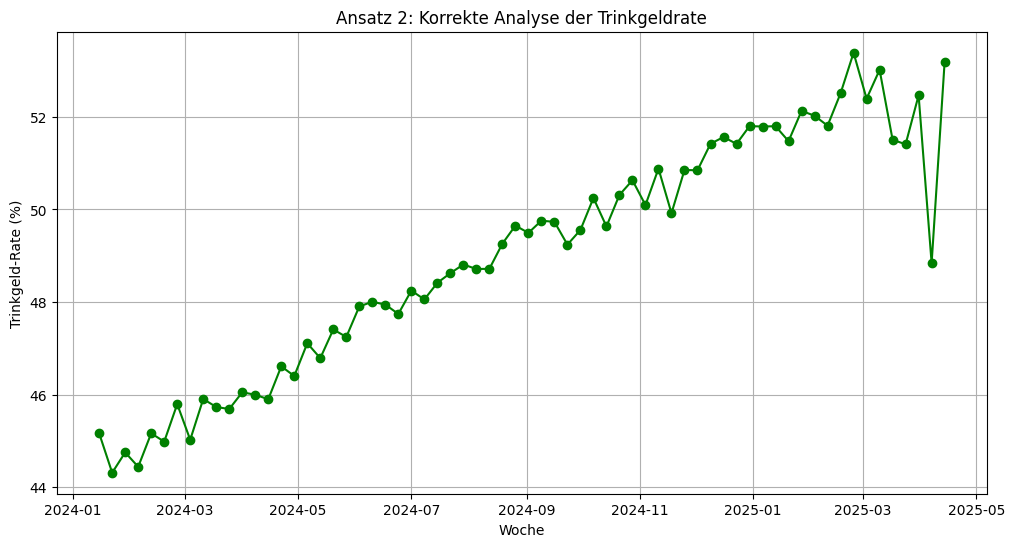

In [18]:
# --- Schritt 3: Ansatz 2 replizieren ---

# Daten mit left join verbinden (gleicher Schritt wie oben)
orders_ext_all_v2 = pd.merge(orders, tips[['order_id', 'tip']], on='order_id', how='left')

# Wochen über Kalenderwochen bestimmen
orders_ext_all_v2['week'] = orders_ext_all_v2['order_date'].dt.to_period('W').dt.start_time

# Berechnung der Rate pro Woche mit .mean()
# WICHTIG: .mean() ignoriert standardmäßig NaN-Werte!
weekly_tips_v2 = orders_ext_all_v2.groupby('week')['tip'].mean() * 100

# Plot erstellen
plt.figure(figsize=(12, 6))
plt.plot(weekly_tips_v2.index, weekly_tips_v2.values, marker='o', color='green')
plt.xlabel('Woche')
plt.ylabel('Trinkgeld-Rate (%)')
plt.title('Ansatz 2: Korrekte Analyse der Trinkgeldrate')
plt.grid(True)
plt.show()

**Erklärung der Lösung in Version 2**

Dieser Plot zeigt keinen unerklärlichen Abfall mehr. Der Grund ist die Verwendung von .mean().

.mean() ignoriert NaNs: Die pandas-Funktion .mean() berechnet den Mittelwert, indem sie die Summe der Werte durch die Anzahl der nicht-fehlenden Werte teilt.
Korrekte Formel: Effektiv berechnet sie also sum(non-NaN tips) / count(non-NaN tips). Die Bestellungen aus dem Test-Set (mit NaN bei tip) fließen somit weder in den Zähler noch in den Nenner ein.
Ergebnis: Die berechnete Rate ist die tatsächliche Trinkgeldrate der Bestellungen, für die wir eine Information haben. Dieser Ansatz ist also korrekt.

___

### Teil 2: Berechnung des Log-Loss (Aufgabe 2)

**Problemstellung:**

Sie haben ein Modell, das Klassenwahrscheinlichkeiten [...] vorhersagt. [...] Auf einer kleinen Testmenge bestehend aus 5 Instanzen hat Ihr Modell jeweils die folgenden Wahrscheinlichkeiten ausgegeben:
(Hier verweisen wir auf die von Ihnen hochgeladenen Daten)

Berechnen Sie den log-loss Ihres Modells. (Benutzen Sie den natürlichen Logarithmus, d.h. den Logarithmus zur Basis e)
[Kontrollergebnis: 0.14257]

#### 2.1 Theoretische Grundlage: Was ist Log-Loss?

Der Log-Loss (auch logarithmischer Verlust oder Kreuzentropie) ist eine Metrik, die bewertet, wie gut die vorhergesagten Wahrscheinlichkeiten eines Klassifikationsmodells sind.

Die Formel für den durchschnittlichen Log-Loss über n Instanzen lautet:
Log-Loss=− 
n
1
​
  
i=1
∑
n
​
 log( 
p
^
​
  
i,y 
i
​
 
​
 )

Dabei ist 
hatp_i,y_i die vom Modell vorhergesagte Wahrscheinlichkeit für die tatsächlich wahre Klasse y_i der i-ten Instanz.

Kernaussage: Ein Modell wird stark "bestraft" (erhält einen hohen Log-Loss), wenn es der wahren Klasse eine niedrige Wahrscheinlichkeit zuweist (d.h. wenn es sich seiner falschen Vorhersage sehr sicher ist). Ein perfekter Log-Loss wäre 0.

In [19]:
data = {
    'p_0': [0.908108, 0.000000, 0.952381, 0.294118, 0.803030],
    'p_1': [0.091892, 1.000000, 0.047619, 0.705882, 0.196970],
    'true_class': [0, 1, 0, 1, 0]
}
df_logloss = pd.DataFrame(data)

print("Daten für die Log-Loss-Berechnung:")
print(df_logloss)

Daten für die Log-Loss-Berechnung:
        p_0       p_1  true_class
0  0.908108  0.091892           0
1  0.000000  1.000000           1
2  0.952381  0.047619           0
3  0.294118  0.705882           1
4  0.803030  0.196970           0


Nun implementieren wir die Log-Loss-Formel. Der entscheidende Schritt ist, für jede Zeile die Wahrscheinlichkeit auszuwählen, die zur wahren Klasse gehört.

- Wenn true_class == 0, verwenden wir die Wahrscheinlichkeit aus Spalte p_0.
- Wenn true_class == 1, verwenden wir die Wahrscheinlichkeit aus Spalte p_1.

In [20]:
# --- Schritt 2: Log-Loss berechnen ---
import numpy as np

# Für jede Zeile die Wahrscheinlichkeit der wahren Klasse auswählen
# np.where(bedingung, wert_wenn_wahr, wert_wenn_falsch)
p_true_class = np.where(
    df_logloss['true_class'] == 0, # Bedingung
    df_logloss['p_0'],             # Wert, wenn Klasse 0 ist
    df_logloss['p_1']              # Wert, wenn Klasse 1 ist
)

# WICHTIG: Um log(0) zu vermeiden, was -unendlich ergibt, "clippen" wir die 
# Wahrscheinlichkeiten auf einen sehr kleinen Mindest- und Maximalwert.
# Das ist eine gängige Praxis.
epsilon = 1e-15
p_clipped = np.clip(p_true_class, epsilon, 1 - epsilon)

# Berechne den negativen Logarithmus für jede Instanz
individual_log_loss = -np.log(p_clipped)

# Berechne den Mittelwert über alle Instanzen
mean_log_loss = individual_log_loss.mean()

print("Wahrscheinlichkeiten der jeweils wahren Klasse:\n", p_true_class)
print("\nIndividueller Log-Loss pro Instanz:\n", individual_log_loss)
print(f"\nDurchschnittlicher Log-Loss: {mean_log_loss}")

Wahrscheinlichkeiten der jeweils wahren Klasse:
 [0.908108 1.       0.952381 0.705882 0.80303 ]

Individueller Log-Loss pro Instanz:
 [9.63919647e-02 9.99200722e-16 4.87901142e-02 3.48307194e-01
 2.19363206e-01]

Durchschnittlicher Log-Loss: 0.14257049579866649
